In [16]:
from __future__ import division
import numpy as np
from scipy.optimize import root, fsolve, broyden1
from functools import partial
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

# mplstyle.use(['ggplot'])

# defined for 1d use
def Df(u,h):
	return np.diff(np.append(u,u[0]))/h
def df(u,h):
	# return np.diff(np.append(u,u[0]))/h
	return np.diff(np.append(u[-1],u))/h	

class DLSSsolver1d():
	def __init__(self, k, h, scope, uinitial, steps = 1000, savesteps = 10):
		self.h = h
		self.k = k
		self.x = np.linspace(scope[0]+h,scope[1],int((scope[1]-scope[0])/h)+1)
		self.u0 = uinitial(self.x)
		self.u = self.u0
		self.uold = self.u0
		self.steps = steps
		if type(savesteps) == int:
			self.savesteps = range(0,steps,savesteps)
		else:
			self.savesteps = savesteps
		self.usol = [np.insert(self.uold,0,self.uold[-1])]
		self.tt = [0]
	def Nsch(self,u):
		u = u.reshape(self.u.shape)
		H = -1/2*Df(u,self.h)**2/(u**2) - df(Df(u,self.h)/u,self.h)
		umiddle = (np.roll(self.uold,-1)+self.uold)/2
		f = df(umiddle*Df(H,self.h),self.h)
		return f
	def forward_diff(self):
		self.uold = self.u
		self.u = self.u + self.k*self.Nsch()
	def explicit_implicit(self):
		self.uold = self.u
		# g = lambda u:(u - self.uold) - self.k* self.Nsch(u)
		# sol=root(g,self.uold,method='df-sane')
		g = lambda u: ((u - self.uold.flatten()) - self.k* self.Nsch(u))
		sol=root(g,self.uold.flatten(),method='krylov',options={'ftol':1e-5})#,method='lm',options={'xtol':1e-20})#,options={'ftol': 1e-100})#,method='df-sane')#,options={'ftol': 1e-20})
		self.u=sol.x.reshape(self.u.shape)
	def run(self,method):
		self.method = method
		for i in range(self.steps+1):
			if method == 'forward_diff':
				self.forward_diff()
			elif method == 'explicit_implicit':
				self.explicit_implicit()
			else:
				raise Exception('Method not defined!')
			if i in self.savesteps:
				self.usol.append(np.insert(self.u,0,self.u[-1]))
				self.tt.append(self.k*self.steps)
		self.usol = np.array(self.usol)


In [17]:
m = 1
h = 1e-2
k = 1e-7
steps = int(7.2e-4/k)
plttime =np.array([8e-6, 3.2e-5, 1e-4, 7.2e-4])
savesteps = plttime/k
savesteps = [int(s) for s in savesteps]

def runsimulation(m,h,k,steps,savesteps):
  epsi = 1e-3
  u0_fun =  lambda x: (epsi**0.5 + ((1 + np.cos(2*np.pi*x))/2)**m)**2
  scope = [0,1]
  # build the model
  a = DLSSsolver1d(k,h,scope,u0_fun,steps,savesteps)
  a.run('explicit_implicit')
  return a.usol, a.x, a.tt


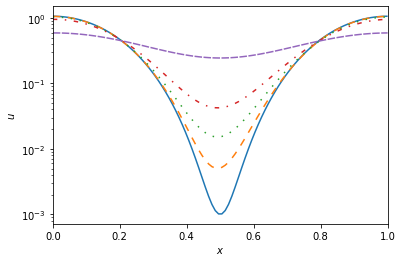

In [18]:
usol,x,t=runsimulation(1,h,k,steps,savesteps)
x = np.insert(x,0,0)
linestyles = OrderedDict(
  [('solid',               (0, ())),
  ('dashed',              (0, (5, 5))),
  ('dotted',              (0, (1, 5))),
  ('dashdotted',          (0, (3, 5, 1, 5))),
    ('densely dashed',      (0, (5, 1)))])

lstyle= [ style for i,(name, style) in enumerate(linestyles.items())]

for i in range(usol.shape[0]):
  plt.semilogy(x,usol[i],linestyle=lstyle[i])
plt.xlim([0,1])
# plt.legend(['0','8e-6','3.2e-5','1e-4','7.2e-4'],title=r'$t$',loc='upper right',bbox_to_anchor=(1.25, 1))
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.savefig('figure/e1E-03m1u.pdf',dpi=300)


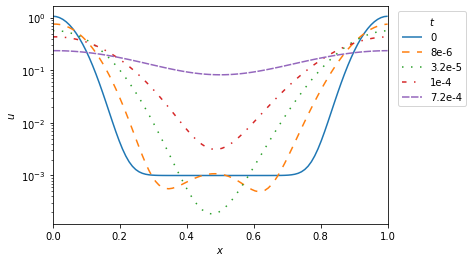

In [19]:
usol2,_,_=runsimulation(8,h,k,steps,savesteps)
linestyles = OrderedDict(
  [('solid',               (0, ())),
  ('dashed',              (0, (5, 5))),
  ('dotted',              (0, (1, 5))),
  ('dashdotted',          (0, (3, 5, 1, 5))),
    ('densely dashed',      (0, (5, 1)))])

lstyle= [ style for i,(name, style) in enumerate(linestyles.items())]

for i in range(usol2.shape[0]):
  plt.semilogy(x,usol2[i],linestyle=lstyle[i])
plt.xlim([0,1])
plt.legend(['0','8e-6','3.2e-5','1e-4','7.2e-4'],title=r'$t$',loc='upper right',bbox_to_anchor=(1.25, 1))
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.savefig('figure/e1E-03m8u.pdf',dpi=300)

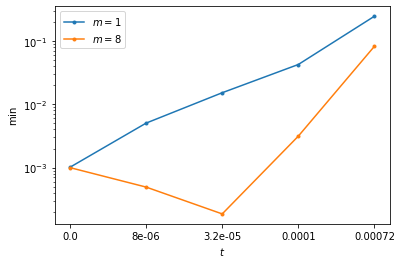

In [20]:
tt = np.insert(plttime,0,0)
plt.semilogy([(np.min(usol[i,:])) for i in range(usol.shape[0])],'.-')
plt.semilogy([(np.min(usol2[i,:])) for i in range(usol.shape[0])],'.-')
# plt.plot(a.tt,[(np.min(a.usol[i,:,1])) for i in range(a.usol.shape[0])])
# plt.plot(a.tt,[(np.min(a.usol[i,:,2])) for i in range(a.usol.shape[0])])
axes = plt.gca()
t11 = [str(i) for i in tt]
plt.xticks(range(len(t11)), t11)
plt.xlabel(r'$t$')
plt.ylabel(r'$\min$')
plt.legend([r'$m=1$',r'$m=8$'])
plt.savefig('figure/min1d.pdf',dpi=300)


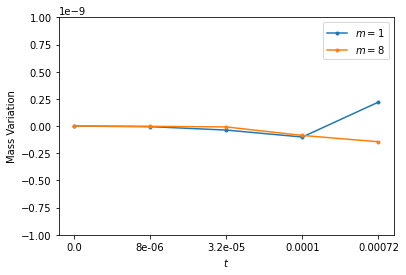

In [21]:
plt.plot([np.sum(usol[i,1:]-usol[0,1:]) for i in range(len(usol))],'.-')
plt.plot([np.sum(usol2[i,1:]-usol2[0,1:]) for i in range(len(usol))],'.-')
axes = plt.gca()
t11 = [str(i) for i in tt]
plt.xticks(range(len(t11)), t11)
plt.xlabel(r'$t$')
plt.ylabel('Mass Variation')
plt.ylim([-1e-9,1e-9])
plt.legend([r'$m=1$',r'$m=8$'])
plt.savefig('figure/mass1d.pdf',dpi=300)


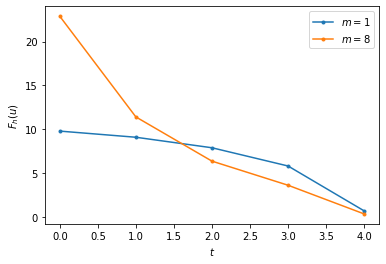

In [22]:
energyf = lambda u: h*np.sum(Df(u,h)**2/u)/2
plt.plot([energyf(usol[i,1:]) for i in range(len(usol))],'.-')
plt.plot([energyf(usol2[i,1:]) for i in range(len(usol))],'.-')
axes = plt.gca()
plt.xlabel(r'$t$')
plt.ylabel(r'$F_h(u)$')
plt.legend([r'$m=1$',r'$m=8$'])
plt.savefig('figure/energy1d.pdf',dpi=300)

In [12]:
hall = [1./10,1./20,1./40,1./80,1./160]
usolall=[]
xall=[]
for i in range(len(hall)):
  h=hall[i]
  k=1e-6
  steps = int(7.2e-4/k)
  plttime =np.array([1e-4, 7.2e-4])
  savesteps = plttime/k
  savesteps = [int(s) for s in savesteps]
  usol,x,t=runsimulation(1,h,k,steps,savesteps)
  usolall.append(usol[-1])
  xall.append(x)



In [13]:
from scipy.interpolate import interp1d
def calerror(x,u,x_r,u_r):
	f = interp1d(x,u)
	errcal = lambda x,y: np.sqrt(np.sum((x-y)**2))
	return errcal(f(x_r),u_r)
err = np.zeros(len(hall)-1)
for i in range(len(hall)-1):
  err[i]=calerror(np.insert(xall[i],0,0),usolall[i][:],np.insert(xall[-1],0,0),usolall[-1][:])

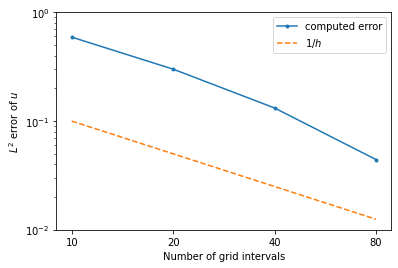

In [14]:
plt.semilogy(err,'.-')
plt.semilogy(np.array(hall[:-1]),'--')
plt.ylim([0.01,1])
xi = [str(i) for i in [10,20,40,80]]
plt.xticks(range(len(xi)), xi)
plt.xlabel('Number of grid intervals')
plt.ylabel(r'$L^2$'+' error of ' + r'$u$')
plt.legend(['computed error',r'$1/h$'])
plt.savefig('figure/err1d.pdf',dpi=300)